In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import six

sns.set(style='ticks', context='paper', rc={'font.sans-serif':'Arial', 'pdf.fonttype': 42})

%matplotlib inline


folder = 'figures'

import flotilla

flotilla_dir = '/projects/ps-yeolab/obotvinnik/flotilla_projects'
study = flotilla.embark('singlecell_pnm_figure2_modalities_bayesian', flotilla_dir=flotilla_dir)
not_outliers = study.splicing.singles.index.difference(study.splicing.outliers.index)

psi = study.splicing.singles.ix[not_outliers]
grouped = psi.groupby(study.sample_id_to_phenotype)
psi_filtered = grouped.apply(lambda x: x.dropna(axis=1, thresh=20))


/home/obotvinnik/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:810: UserWarning: Found matplotlib configuration in ~/.matplotlib/. To conform with the XDG base directory standard, this configuration location has been deprecated on Linux, and the new location is now /home/obotvinnik/.config/matplotlib/. Please move your configuration there to ensure that matplotlib will continue to find it in the future.
  _get_xdg_config_dir())
/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/__init__.py:65: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  load_species_data=load_species_data)


2016-05-19 10:38:43	Reading datapackage from /projects/ps-yeolab/obotvinnik/flotilla_projects/singlecell_pnm_figure2_modalities_bayesian/datapackage.json
2016-05-19 10:38:43	Parsing datapackage to create a Study object
2016-05-19 10:39:34 	Initializing Study
2016-05-19 10:39:34 	Initializing Predictor configuration manager for Study
2016-05-19 10:39:34	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2016-05-19 10:39:34	Added ExtraTreesClassifier to default predictors
2016-05-19 10:39:34	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2016-05-19 10:39:34	Added ExtraTreesRegressor to default predictors
2016-05-19 10:39:34	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2016-05-19 10:39:34	Added GradientBoostingClassifier to default predictors
2016-05-19 10:39:34	Predictor GradientBoostingRegressor is of type <class 'sklear

In [16]:
! grep "pooled" *.ipynb

2.2_Figure_2,_part_3_-_Modality_properites_bayesian_pooled_inconsistent.ipynb:    "### Modality bar graph of events inconsistent with pooled"
2.2_Figure_2,_part_3_-_Modality_properites_bayesian_pooled_inconsistent.ipynb:      "  not_measured_in_pooled = singles.columns.diff(pooled.columns)\n"
2.2_Figure_2,_part_3_-_Modality_properites_bayesian_pooled_inconsistent.ipynb:    "modalities_inconsistent = study.percent_pooled_inconsistent(\n",
2.2_Figure_2,_part_3_-_Modality_properites_bayesian_pooled_inconsistent.ipynb:    "pooled_inconstent_folder = '{}/pooled_inconsistent_delta_psi'.format(folder)\n",
2.2_Figure_2,_part_3_-_Modality_properites_bayesian_pooled_inconsistent.ipynb:    "! mkdir $pooled_inconstent_folder"
2.2_Figure_2,_part_3_-_Modality_properites_bayesian_pooled_inconsistent.ipynb:    "pooled_grouped = study.splicing.pooled.groupby(study.sample_id_to_phenotype)\n",
2.2_Figure_2,_part_3_-_Modality_properites_bayesian_pooled_inconsistent.ipynb:    "pooled_inconsistent_dir = '{}

### Enrichment of this modality, within phenotype

i.e. *"What GO categories are iPSC bimodal events enriched for, compared to other modalities in iPSC?"*

In [2]:
figure_folder = '{}/gene_ontology'.format(folder)
! mkdir $figure_folder

mkdir: cannot create directory `figures/gene_ontology': File exists


In [3]:
study.splicing.feature_expression_id_col = 'ensembl_id'

In [4]:
np.finfo(np.float128).eps

1.084202172485504434e-19

In [13]:
all_bimodal_events = study.supplemental.modalities_tidy.query('modality == "bimodal"')['event_id'].unique()
len(all_bimodal_events)

5602

/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/data_model/gene_ontology.py:184: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  columns=['negative_log_p_value'], ascending=False)
/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/visualize/gene_ontology.py:20: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  data = data.sort(x_col, ascending=False)


MN
	bimodal
	excluded
	included
	uncategorized
... empty GO enrichment!
NPC
	bimodal
	excluded
	included
	uncategorized
... empty GO enrichment!
iPSC
	bimodal
	excluded
	included
	middle
... empty GO enrichment!
	uncategorized


/home/obotvinnik/anaconda/lib/python2.7/site-packages/flotilla/data_model/gene_ontology.py:173: UserWarning: No GO categories enriched in provided features
  warnings.warn('No GO categories enriched in provided features')


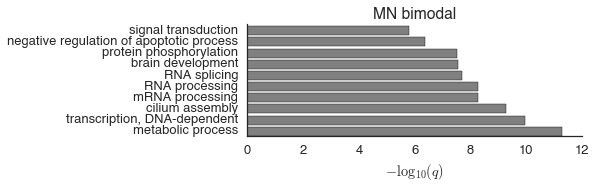

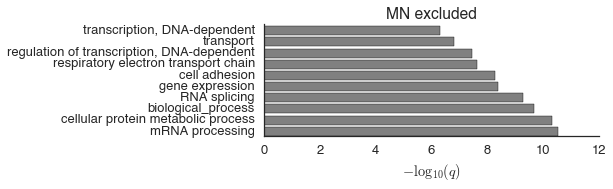

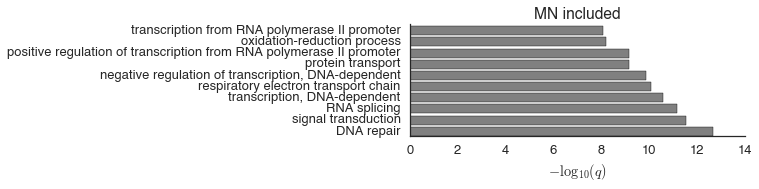

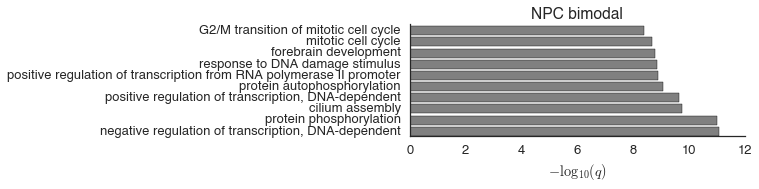

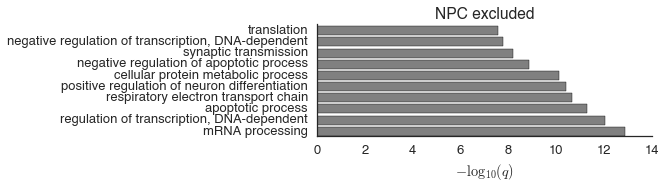

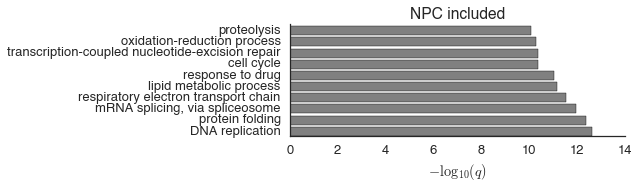

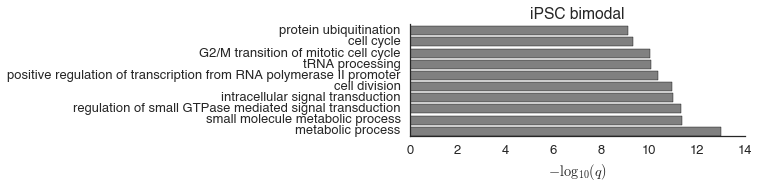

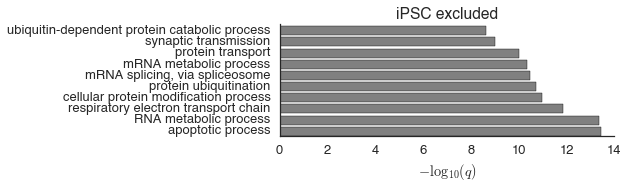

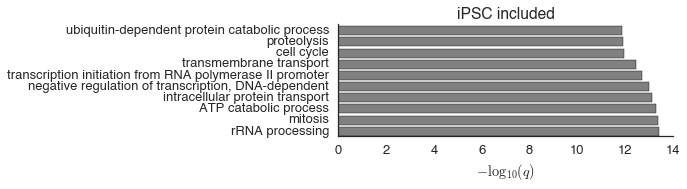

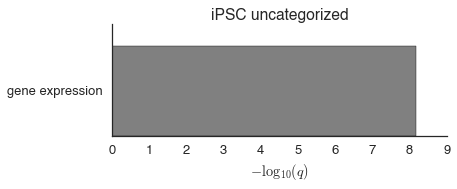

In [5]:
from flotilla.visualize.gene_ontology import plot_go_enrichment
gos = []
for (phenotype), phenotype_df in study.supplemental.modalities_tidy.groupby(['phenotype']):
    print phenotype
    background = study.splicing.splicing_to_expression_id(phenotype_df.event_id)
    for modality, modality_df in phenotype_df.groupby('modality'):
        print '\t', modality
        modality_genes = study.splicing.splicing_to_expression_id(modality_df.event_id)
        go = study.go_enrichment(modality_genes, background, #p_value_cutoff=0.01, 
                                 min_feature_size=5, min_background_size=10,
                                 domain='biological_process')
        if go is None or go.empty:
            print '... empty GO enrichment!'
            continue
        go = go.iloc[:10, :]
        fig, ax = plt.subplots(figsize=(6, 2))
        ax = plot_go_enrichment(data=go, color='grey')
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
#         fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_within_celltype_{}_{}.pdf'.format(figure_folder, modality, phenotype))

MN
	bimodal
	excluded
	included
	uncategorized
... empty GO enrichment!
NPC
	bimodal
	excluded
	included
	uncategorized
... empty GO enrichment!
iPSC
	bimodal
	excluded
	included
	middle
... empty GO enrichment!
	uncategorized


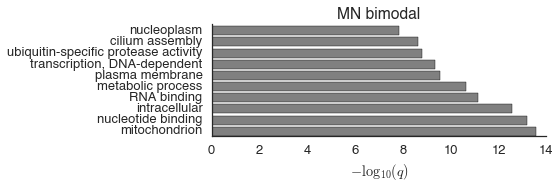

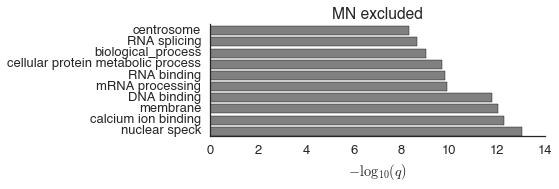

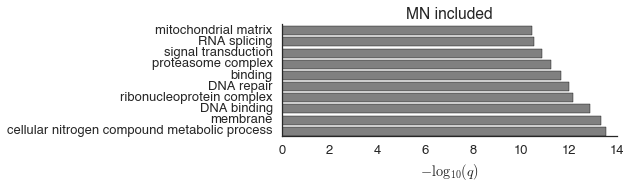

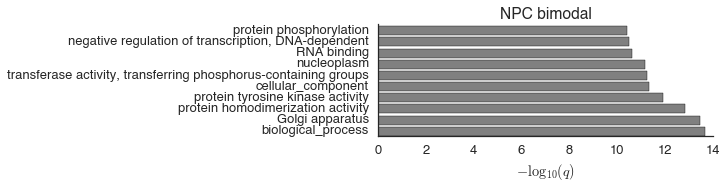

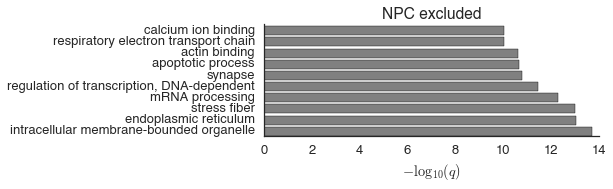

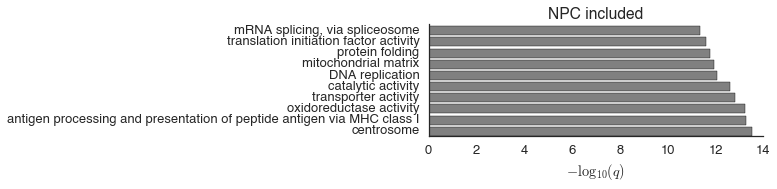

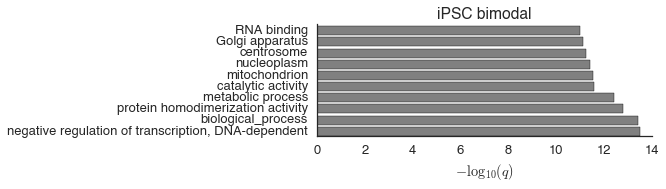

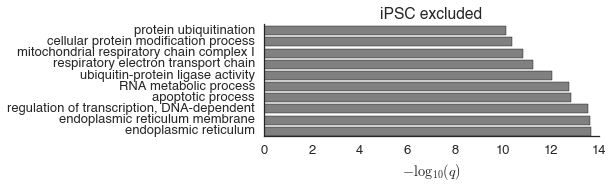

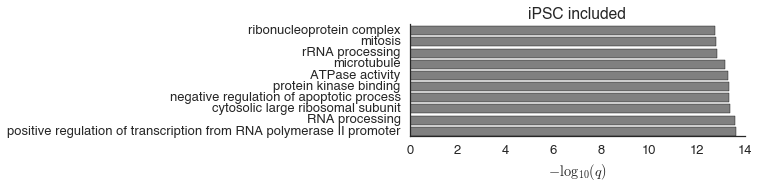

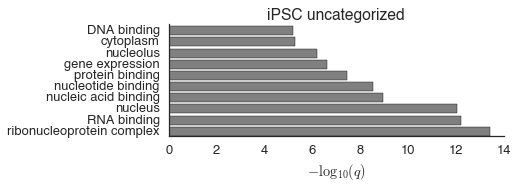

In [11]:
from flotilla.visualize.gene_ontology import plot_go_enrichment
gos = []
for (phenotype), phenotype_df in study.supplemental.modalities_tidy.groupby(['phenotype']):
    print phenotype
    background = study.splicing.splicing_to_expression_id(phenotype_df.event_id)
    for modality, modality_df in phenotype_df.groupby('modality'):
        print '\t', modality
        modality_genes = study.splicing.splicing_to_expression_id(modality_df.event_id)
        go = study.go_enrichment(modality_genes, background, #p_value_cutoff=0.01, 
                                 min_feature_size=5, min_background_size=10)
        if go is None or go.empty:
            print '... empty GO enrichment!'
            continue
        go = go.iloc[:10, :]
        fig, ax = plt.subplots(figsize=(6, 2))
        ax = plot_go_enrichment(data=go, color='grey')
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
#         fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_within_celltype_{}_{}_all_domains.pdf'.format(figure_folder, modality, phenotype))

In [6]:
plot_go_enrichment??

In [7]:
go

,features_of_interest_in_go_term,features_of_interest_in_go_term_gene_symbols,go_domain,go_name,n_background_in_go_term,n_features_of_interest_in_go_term,n_features_total_in_go_term,negative_log_p_value,bonferonni_corrected_negative_log_p_value
GO:0010467,"ENSG00000197111,ENSG00000125944,ENSG0000016821...","PCBP2,HNRNPR,RBPJ,EIF4A2,HNRNPD,RNMT",biological_process,gene expression,398,6,771,9.261398,8.162786


### Enrichment of this modality, across phenotypes

i.e. *"What GO categories are iPSC bimodal events enriched for, compared to bimodal events in NPC and MN?"*

bimodal
	MN
	NPC
	iPSC
excluded
	MN
	NPC
	iPSC
included
	MN
	NPC
	iPSC
middle
	iPSC
	... empty GO enrichment!
uncategorized
	MN
	... empty GO enrichment!
	NPC
	... empty GO enrichment!
	iPSC


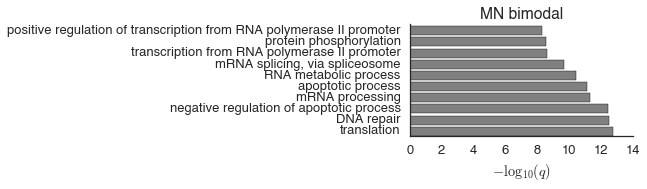

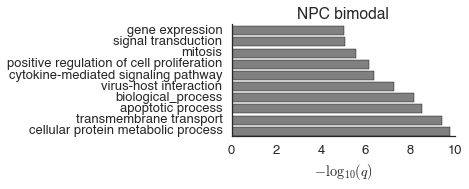

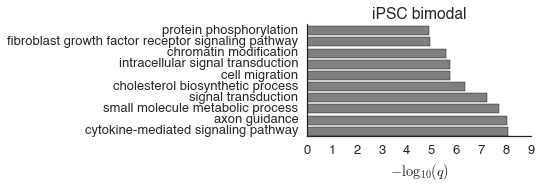

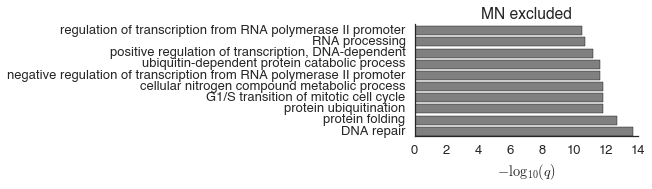

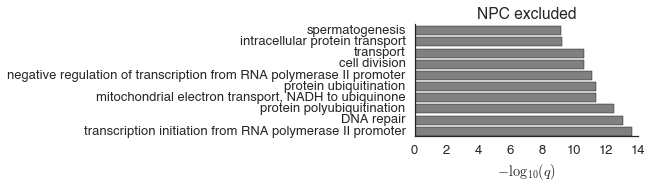

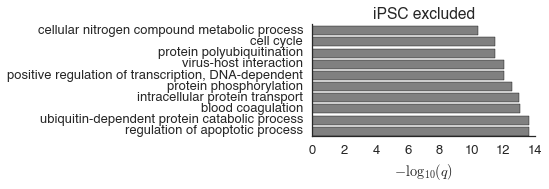

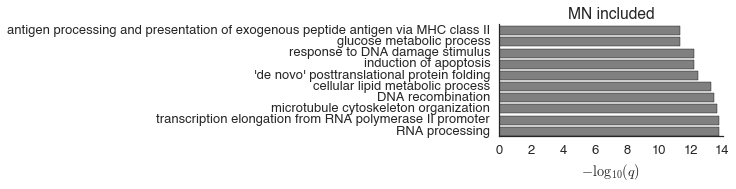

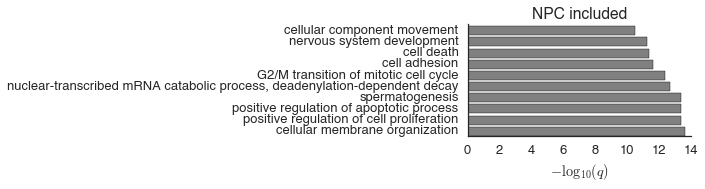

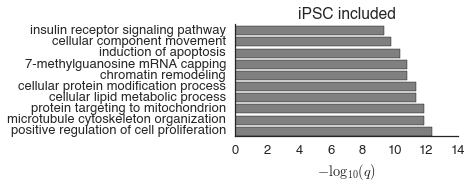

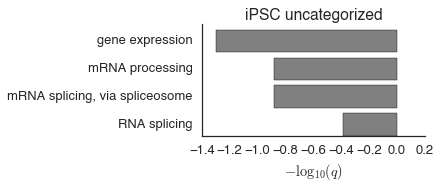

In [8]:
import itertools

modalities_all_celltypes = study.supplemental.modalities_tidy.groupby('event_id').filter(
    lambda x: len(x)==len(study.phenotype_order))

go_dfs = []

for (modality), modality_df in modalities_all_celltypes.groupby(['modality']):
    print modality
    background = study.splicing.splicing_to_expression_id(modality_df.event_id)
    for phenotype, phenotype_df in modality_df.groupby('phenotype'):
        print '\t', phenotype
        phenotype_genes = study.splicing.splicing_to_expression_id(phenotype_df.event_id)
        go = study.go_enrichment(phenotype_genes, background, #p_value_cutoff=0.01, 
#                                  min_feature_size=5, min_background_size=10,
                                domain='biological_process')
        if go is None or go.empty:
            print '\t... empty GO enrichment!'
            continue
            
        go['modality'] = modality
        go['phenotype'] = phenotype
        go_dfs.append(go.reset_index())
        fig, ax = plt.subplots(figsize=(4, 2))
        ax = plot_go_enrichment(data=go, color='grey')
        ax.set_title('{} {}'.format(phenotype, modality))
        fig = plt.gcf()
#         fig.tight_layout()
        fig.savefig('{}/modality_go_enrichment_across_celltypes_{}_{}.pdf'.format(figure_folder, phenotype, modality))
go_df = pd.concat(go_dfs, ignore_index=True)

### Enrichment of this modality vs all other modalities across phenotypes

i.e. *"What GO categories are bimodal events in iPSC, NPC and MN enriched for, over other modalities in those celltypes?"*

In [9]:
modalities_all_celltypes = study.supplemental.modalities_tidy.groupby('event_id').filter(
    lambda x: len(x) == len(study.phenotype_order))

bimodal
excluded
included
middle
	... empty GO enrichment!
uncategorized


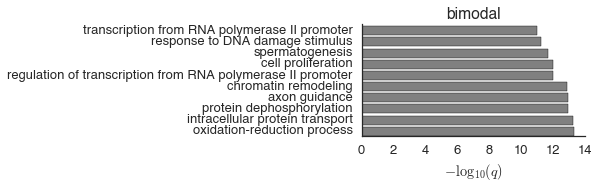

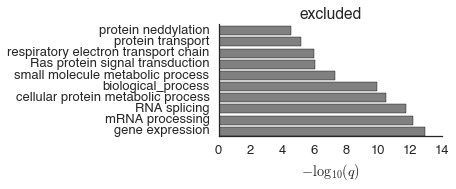

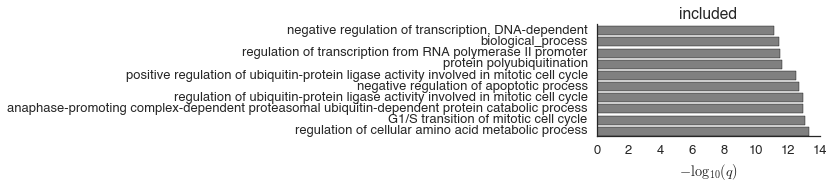

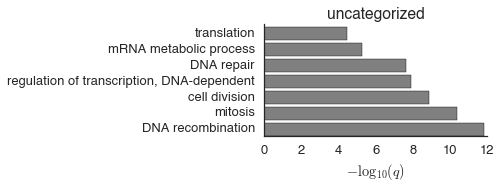

In [10]:
import itertools

background = study.splicing.splicing_to_expression_id(modalities_all_celltypes.event_id)


for (group), df1 in modalities_all_celltypes.groupby(['modality']):
    print group
    foreground = study.splicing.splicing_to_expression_id(df1.event_id)
    go = study.go_enrichment(foreground, background, #p_value_cutoff=0.1, 
#                              min_feature_size=5, min_background_size=10,
                             domain='biological_process')
    if go is None or go.empty:
        print '\t... empty GO enrichment!'
        continue

    fig, ax = plt.subplots(figsize=(4, 2))
    ax = plot_go_enrichment(data=go, color='grey')
    ax.set_title(group)
    fig = plt.gcf()
#     fig.tight_layout()
    fig.savefig('{}/modality_go_enrichment_across_celltypes_{}.pdf'.format(figure_folder, group))